## Imports

In [53]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.metrics import f1_score, classification_report

In [54]:
PREPROCESSED_DATA_PATH = "../../../data/preprocessed/"

## Read Data

In [55]:
train_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "train.parquet")

val_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "validation.parquet")
small_test_df = pd.read_parquet(PREPROCESSED_DATA_PATH + "test.parquet")

test_df = pd.concat([val_df, small_test_df], axis=0)

## Split Data Into Training and Testing

In [56]:
TARGET = 'copiesSold'

X_train = train_df.drop(columns=TARGET)
y_train = train_df[TARGET]

X_test = test_df.drop(columns=TARGET)
y_test = test_df[TARGET]

In [57]:
pd.set_option('display.max_columns', None)
X_train.head()

,steam_achievements,steam_trading_cards,workshop_support,achievements_total,is_release_date_known,is_upcoming,year,sin_day,cos_day,price,reviewScore,has_demo,demo_count,has_dlc,dlc_count,metacritic_preprocessed,has_metacritic,genre_Action,genre_Adventure,genre_Casual,genre_Early Access,genre_Free To Play,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Other,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Sports,genre_Strategy,genre_Violent,platform_linux,platform_mac,platform_windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest,publisherClass_Indie,publisherClass_Other
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11655,0,0,0,-0.127185,1,0.0,2024,0.230306,-0.973118,-0.959158,-0.331901,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.129008,-0.485228,-0.422150,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
9303,0,0,0,-0.127185,1,0.0,2024,-0.060213,-0.998186,-1.631332,1.072290,0,0,0,0,0.0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.430898,0.109341,0.140908,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0
56618,0,0,0,-0.127185,1,0.0,2007,0.179767,-0.983709,-0.061180,-0.331901,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.575401,0.109341,0.301146,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
55579,1,0,0,0.105103,1,0.0,2019,-0.188227,0.982126,-1.631332,-0.331901,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-0.129008,0.703911,0.243282,-0.241008,7.064584,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,1.0,0.0
64439,1,0,0,-0.069113,1,0.0,2022,0.280231,-0.959933,-1.631332,1.180305,0,0,1,1,0.0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,-0.833418,-1.079798,-0.496087,-0.241008,-0.141551,-0.018005,-0.025111,-0.045946,-0.125187,-0.012731,0.0,0.0,0.0


In [58]:
y_train.head()

index
11655    0
9303     0
56618    0
55579    1
64439    1
Name: copiesSold, dtype: int64

## Check Data Balance

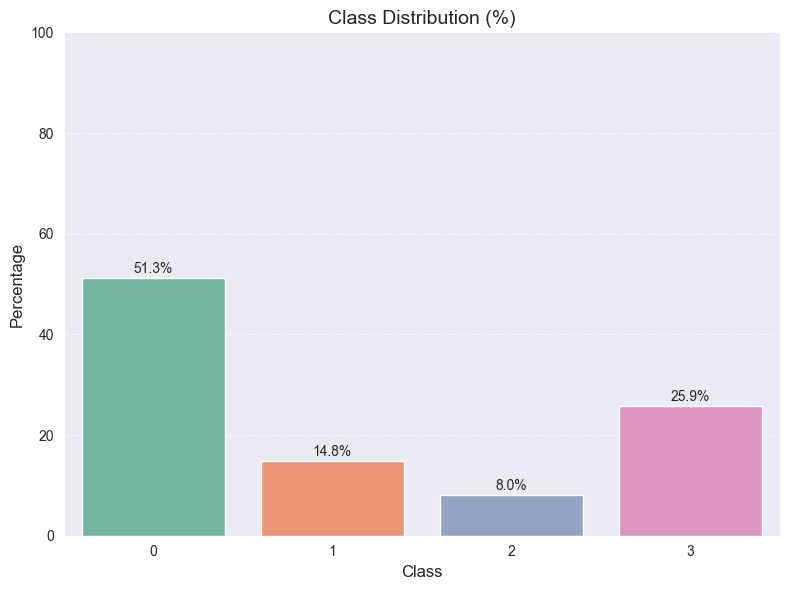

In [59]:
# Calculate class distribution percentages
class_percentages = y_train.value_counts(normalize=True).sort_index() * 100
df_plot = pd.DataFrame({
    'Class': class_percentages.index,
    'Percentage': class_percentages.values
})

plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_plot,
    x='Class',
    y='Percentage',
    hue='Class',
    palette='Set2',
    legend=False
)

plt.title('Class Distribution (%)', fontsize=14)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(df_plot['Percentage']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Define Models and Hyperparameter Grids

In [60]:
models = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {
            'C': [0.01, 0.1, 1],
            'fixed': {
                'solver': 'liblinear',
                'max_iter': 1000,
                'class_weight': 'balanced',
                'penalty': 'l2',
                'random_state': 42
            }
        }
     },
    'LinearSVC': {
        'class': LinearSVC,
        'params': {
            'C': [0.1, 1.0, 10, 100],
            'fixed': {
                'max_iter': 10000,
                'dual' : False,
                'loss': 'squared_hinge',
                'class_weight': 'balanced',
                'penalty': 'l2',
                'random_state': 42
            }
        }
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'fixed': {
                'eval_metric': 'mlogloss',
                'n_jobs': -1,
                'random_state': 42,

            }
        }
    }
}

## Feature Selection and Hyperparameter Tuning

In [61]:
best_params = {}
best_selectors = {}
best_models = {}
tuning_results = {model_name: {} for model_name in models.keys()}

for model_name, config in models.items():
    print(f"\n=== Tuning {model_name} ===")

    model_class = config['class']
    fixed_params = config['params'].get('fixed', {})
    current_best_params = fixed_params.copy()  # Start with fixed params

    for param_name, param_values in config['params'].items():
        if param_name == 'fixed':
            continue

        print(f"\nTuning {param_name}...")

        best_score = -np.inf
        param_scores = []

        for value in param_values:
            print(f"  Testing {param_name}={value}")

            # Fix previous best parameters, update only current parameter
            test_params = {**current_best_params, param_name: value}

            model = model_class(**test_params)

            selector = RFECV(
                estimator=model,
                cv = 3,
                scoring = 'accuracy',
                n_jobs = -1,
                verbose = 0
            )

            X_selected = selector.fit_transform(X_train, y_train)
            print(f"    Selected {X_selected.shape[1]} features")

            score = cross_val_score(
                model,
                X_selected,
                y_train,
                cv = 3,
                scoring = 'accuracy',
                n_jobs=  -1,
                verbose = 0
            ).mean()
            print(f"    Accuracy: {score:.4f}")

            param_scores.append(score)

            # Update best parameter
            if score > best_score:
                best_score = score
                current_best_params[param_name] = value
                best_selector = selector
                print(f"    New best score: {score:.4f}")

        tuning_results[model_name][param_name] = {
            'values': param_values,
            'scores': param_scores
        }

    # After tuning all params sequentially, fit final model
    best_params[model_name] = current_best_params
    final_model = model_class(**current_best_params)
    final_model.fit(best_selector.transform(X_train), y_train)
    best_models[model_name] = final_model
    best_selectors[model_name] = best_selector



=== Tuning LogisticRegression ===

Tuning C...
  Testing C=0.01


KeyboardInterrupt: 

## Visualizing Hyperparameter Tuning Results

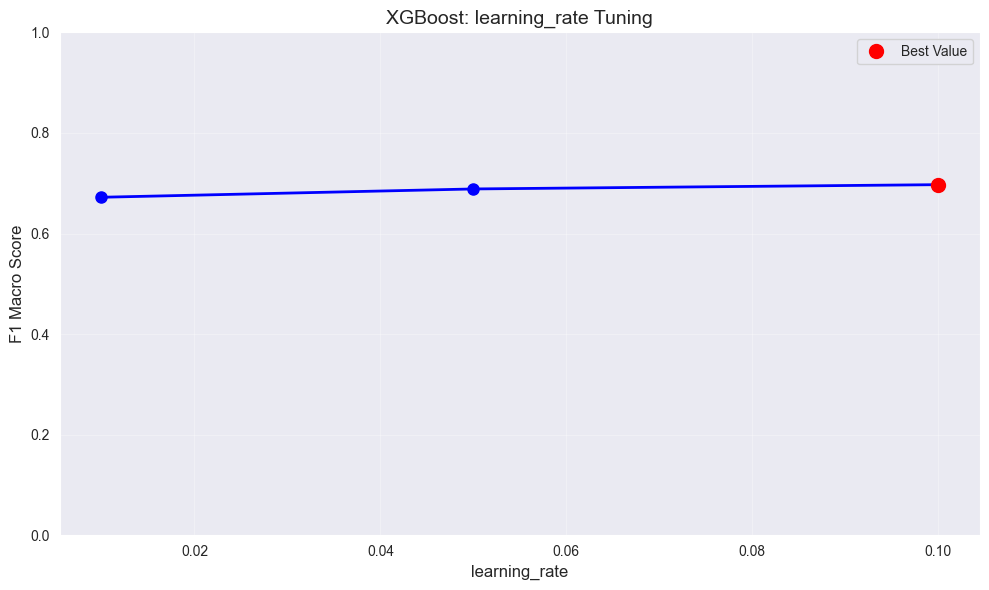

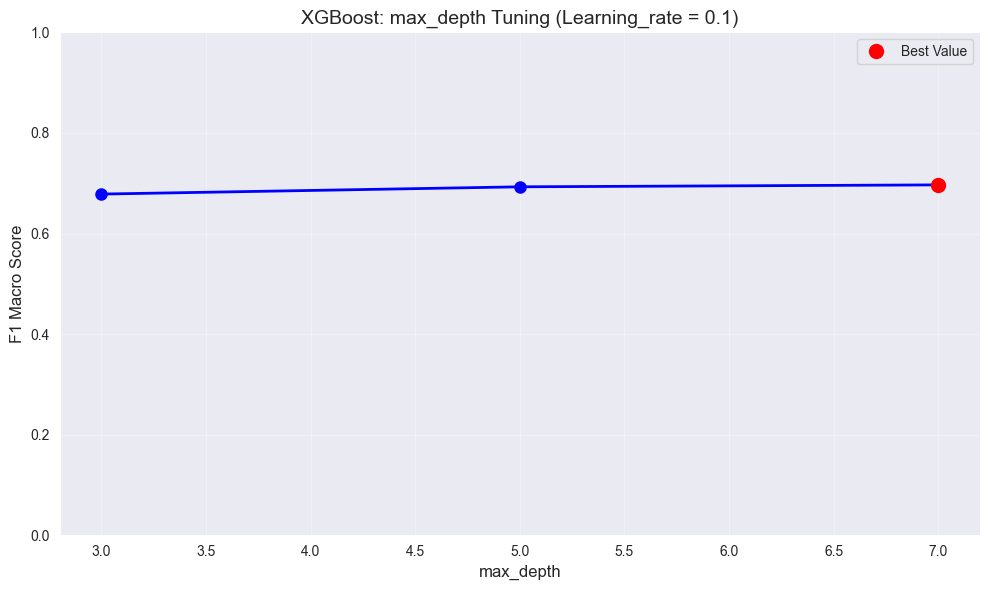

In [41]:
# --- Visualization ---
for model_name, param_data in tuning_results.items():
    for param_name, data in param_data.items():
        plt.figure(figsize=(10, 6))

        # Line plot for numeric parameters
        plt.plot(data['values'], data['scores'], 'bo-', markersize=8, linewidth=2)
        best_val = best_params[model_name].get(param_name)

        if best_val is not None and best_val in data['values']:
            best_idx = data['values'].index(best_val)
            plt.plot(best_val, data['scores'][best_idx], 'ro', markersize=10, label='Best Value')

            plt.legend()

        # Customize title for XGBoost max_depth to include fixed learning_rate
        if model_name == 'XGBoost' and param_name == 'max_depth':
            lr = best_params[model_name].get('learning_rate', None)
            if lr is not None:
                title = f'{model_name}: {param_name} Tuning (Learning_rate = {lr})'
            else:
                title = f'{model_name}: {param_name} Tuning'
        else:
            title = f'{model_name}: {param_name} Tuning'

        plt.title(title, fontsize=14)
        plt.xlabel(param_name, fontsize=12)
        plt.ylabel('F1 Macro Score', fontsize=12)  # Changed from Accuracy to F1
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


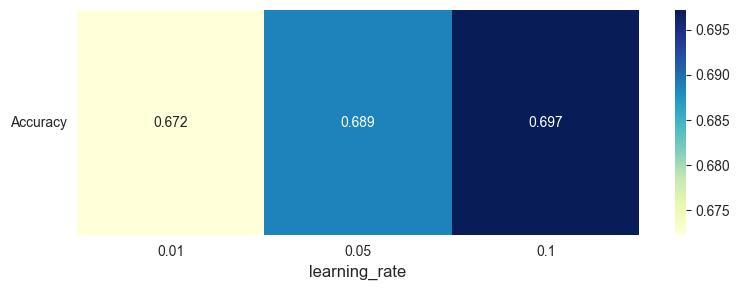

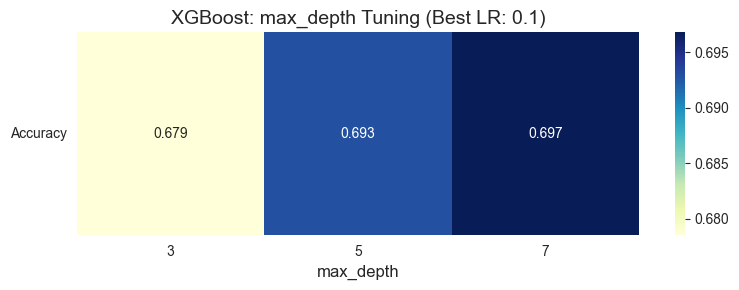

In [43]:
# --- Heatmap Visualization ---
for model_name, param_data in tuning_results.items():
    for param_name, data in param_data.items():
        df_plot = pd.DataFrame({
            param_name: data['values'],
            'Accuracy': data['scores']
        })


        df_heat = df_plot.set_index(param_name).T

        plt.figure(figsize=(max(8, len(df_heat.columns)*0.7), 3))  # Increased height
        sns.heatmap(df_heat, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
                   annot_kws={'fontsize':10})

        # ADDED: Show relationship in title
        if model_name == 'XGBoost':
            if param_name == 'max_depth':
                lr = best_params[model_name].get('learning_rate', 'N/A')
                plt.title(f'{model_name}: {param_name} Tuning (Best LR: {lr})', fontsize=14)
        else:
            plt.title(f'{model_name}: {param_name} Tuning', fontsize=14)

        plt.xlabel(param_name, fontsize=12)
        plt.yticks(rotation=0)  # Show y-label
        plt.tight_layout()
        plt.show()

## Training and Testing

['XGBoost']
[0.704]


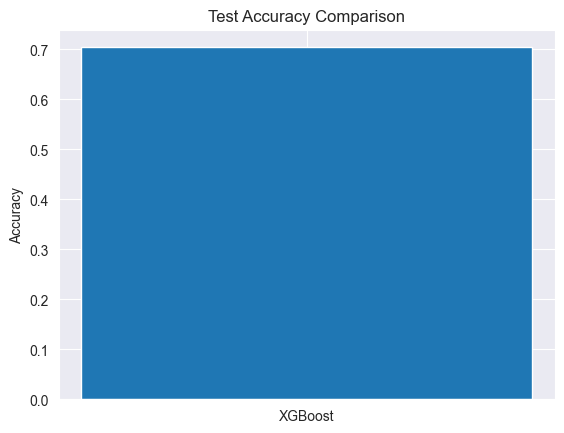

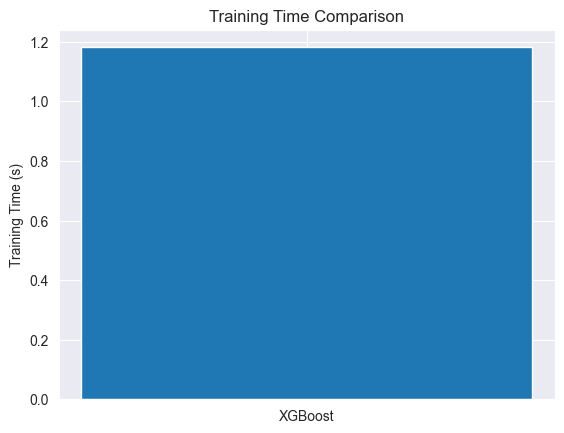

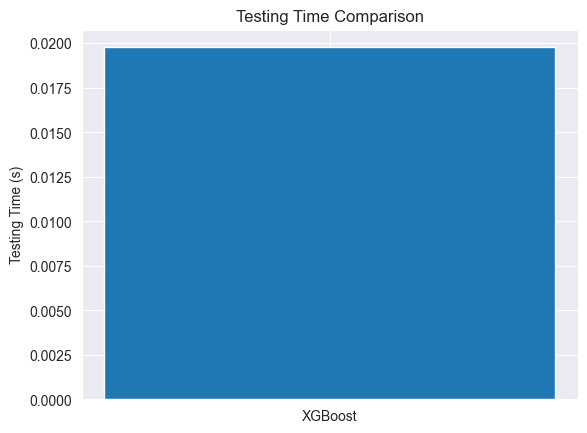

In [38]:
# Train final models and collect metrics
train_times = {}
test_times = {}
accuracies = {}

for model_name in models.keys():
    # Retrieve model class and params
    model_class = models[model_name]['class']
    fixed_params = models[model_name]['params'].get('fixed', {})

    # Get selected features
    selector = best_selectors[model_name]
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    # Create and train model
    model = model_class(**{**fixed_params, **best_params[model_name]})

    #  # Print classification report
    # print(classification_report(
    #     y_test, y_pred, target_names=['Bronze', 'Silver', 'Gold', 'Platinum']
    # ))
     # Training
    start = time.time()
    model.fit(X_train_sel, y_train)
    train_times[model_name] = time.time() - start

    # Testing
    start = time.time()
    y_pred = model.predict(X_test_sel)
    test_times[model_name] = time.time() - start

    # Accuracy
    accuracies[model_name] = accuracy_score(y_test, y_pred)

# Bar plot: Test Accuracy
print(list(accuracies.keys()))
print(list(round(accuracy, 3) for accuracy in accuracies.values()))
plt.figure()
plt.bar(list(accuracies.keys()), list(accuracies.values()))
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.show()

# Bar plot: Training Time
plt.figure()
plt.bar(list(train_times.keys()), list(train_times.values()))
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison')
plt.show()

# Bar plot: Testing Time
plt.figure()
plt.bar(list(test_times.keys()), list(test_times.values()))
plt.ylabel('Testing Time (s)')
plt.title('Testing Time Comparison')
plt.show()

